# Build a character importance score

The idea is to gather data from the main characters of a movie, to then understand how important the character is, and therefore how important the actor is. This way we can build an "importancy metric" to display how women position according to it, and try to extract meaningful conclusions from it.

In [25]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import glob

# Get data from characters

Use character.metadata.tsv and collect the interesting data to then build a metric for each movie:
- Number of characters data
- Proportion of women in this set
- ImdB rating
- Number of votes


In [50]:
# Get character data from Data/MovieSummaries/character.metadata.tsv
character_data = pd.read_csv('Data/MovieSummaries/character.metadata.tsv', sep='\t', header=None)
character_data.columns = ['wiki_movie_ID','freebase_movie_ID','movie_release_date',\
    'character_name','actor_DOB','actor_gender','actor_height','actor_ethnicity',\
        'actor_name','actor_age_movie','freebase_char/actor_map_ID','freebase_char_ID','freebase_actor_ID']

# Drop all characters without a actor_gender
character_data = character_data.drop(character_data[character_data.actor_gender == '\\N'].index)

,wiki_movie_ID,freebase_movie_ID,movie_release_date,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_movie,freebase_char/actor_map_ID,freebase_char_ID,freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


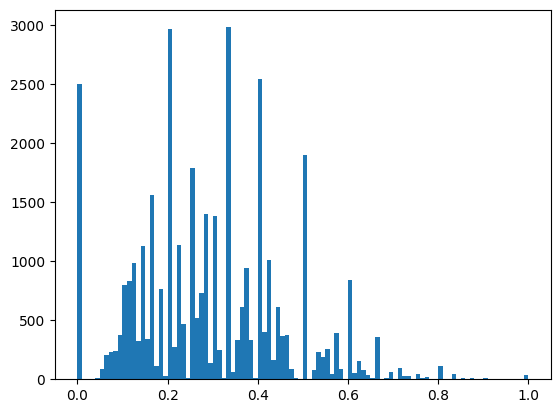

In [45]:
# Get all movie that appear in character_data variable
movie_list = character_data['wiki_movie_ID'].unique()

# Remove empty values from movie_list
movie_list = movie_list[~pd.isnull(movie_list)]

# Create a dataframe with all movie ID
movie_character = pd.DataFrame({'wiki_movie_ID': movie_list})

# Add a column "freebase_movie_id" with the corresponding freebase ID
movie_character['freebase_movie_ID'] = movie_character['wiki_movie_ID'].map(dict(zip(character_data['wiki_movie_ID'],\
     character_data['freebase_movie_ID'])))

# Get number of character per movie
character_per_movie = character_data.groupby('wiki_movie_ID').size().reset_index(name='counts')

# Get number of character played by a female actor per movie
character_f_per_movie = character_data[character_data['actor_gender'] == 'F'].groupby('wiki_movie_ID').size().reset_index(name='counts')

# Build dataframe with movie ID and columns for the number of character, the number of character played by a woman
movie_character = pd.merge(movie_character, character_per_movie, on='wiki_movie_ID', how='left')
movie_character = pd.merge(movie_character, character_f_per_movie, on='wiki_movie_ID', how='left')

# Change column name to nb_character and nb_f_character
movie_character = movie_character.rename(columns={'counts_x': 'nb_character', 'counts_y': 'nb_f_character'})

# Create new column with the ratio of female actor in percentage
movie_character['F_actor_ratio'] = movie_character['nb_f_character'] / movie_character['nb_character']

# Keep only movie with at least 5 character
movie_character = movie_character[movie_character['nb_character'] >= 5]

# fill NaN with 0
movie_character = movie_character.fillna(0)

# Convert nb_f_character to int
movie_character['nb_f_character'] = movie_character['nb_f_character'].astype(int)



In [49]:
# Open Data/Imdb/processed_imdb_dataset.csv as a dataframe
imdb_data = pd.read_csv('Data/Imdb/processed_imdb_dataset.csv')

# From imdb_data, add to movie_character the columns averageRating and numVotes
movie_character = pd.merge(movie_character, imdb_data[['freebase_movie_ID','averageRating','numVotes']], on='freebase_movie_ID', how='left')

# Drop all rows with NaN
movie_character = movie_character.dropna()

# Re-index movie_character
movie_character = movie_character.reset_index(drop=True)

movie_character

,wiki_movie_ID,freebase_movie_ID,nb_character,nb_f_character,F_actor_ratio,averageRating_x,numVotes_x,averageRating_y,numVotes_y,averageRating,numVotes
0,975900,/m/03vyhn,17,6,0.352941,4.9,55271.0,4.9,55271.0,4.9,55271
1,2238856,/m/06yc6v,15,8,0.533333,7.2,36616.0,7.2,36616.0,7.2,36616
2,24229100,/m/07kjkz6,5,2,0.400000,6.3,3817.0,6.3,3817.0,6.3,3817
3,156558,/m/014k4y,37,12,0.324324,6.4,15014.0,6.4,15014.0,6.4,15014
4,9633533,/m/02pml15,9,2,0.222222,7.9,1198.0,7.9,1198.0,7.9,1198
...,...,...,...,...,...,...,...,...,...,...,...
26363,21772949,/m/05mspcd,10,3,0.300000,6.0,518.0,6.0,518.0,6.0,518
26364,24997872,/m/09g6klx,7,1,0.142857,5.0,1286.0,5.0,1286.0,5.0,1286
26365,2828945,/m/085bgh,9,3,0.333333,6.2,2649.0,6.2,2649.0,6.2,2649
26366,22545667,/m/05zrrsp,11,5,0.454545,5.9,69.0,5.9,69.0,5.9,69


# Elements to build a score

Get all the movies for which we have character metadata
For each movie get:
- Movie ID
- number of characters
- Ratio of female actors
- Number of movies done by each actors

$$ score(actor) =\#movie(actor) * \sum\limits_{movie \in career(actor)} IMdB_{vote}(movie)  $$

# Career building

It can be assumed that an actor who has been in multiple films has had a more successful career than one who has only been in one, and therefore has a higher importancy score.

For each actor build its score, then show the distribution of the score overall, for men, and for women
